RGB Image Path: D:\Priya\125003238\rgb_input\11473.jpg
Thermal Image Path: D:\Priya\125003238\254p Thermal Images\11473.jpg
Converting thermal image to grayscale...
RGB Image Shape: (254, 254, 3)
Thermal Image Gray Shape: (254, 254)


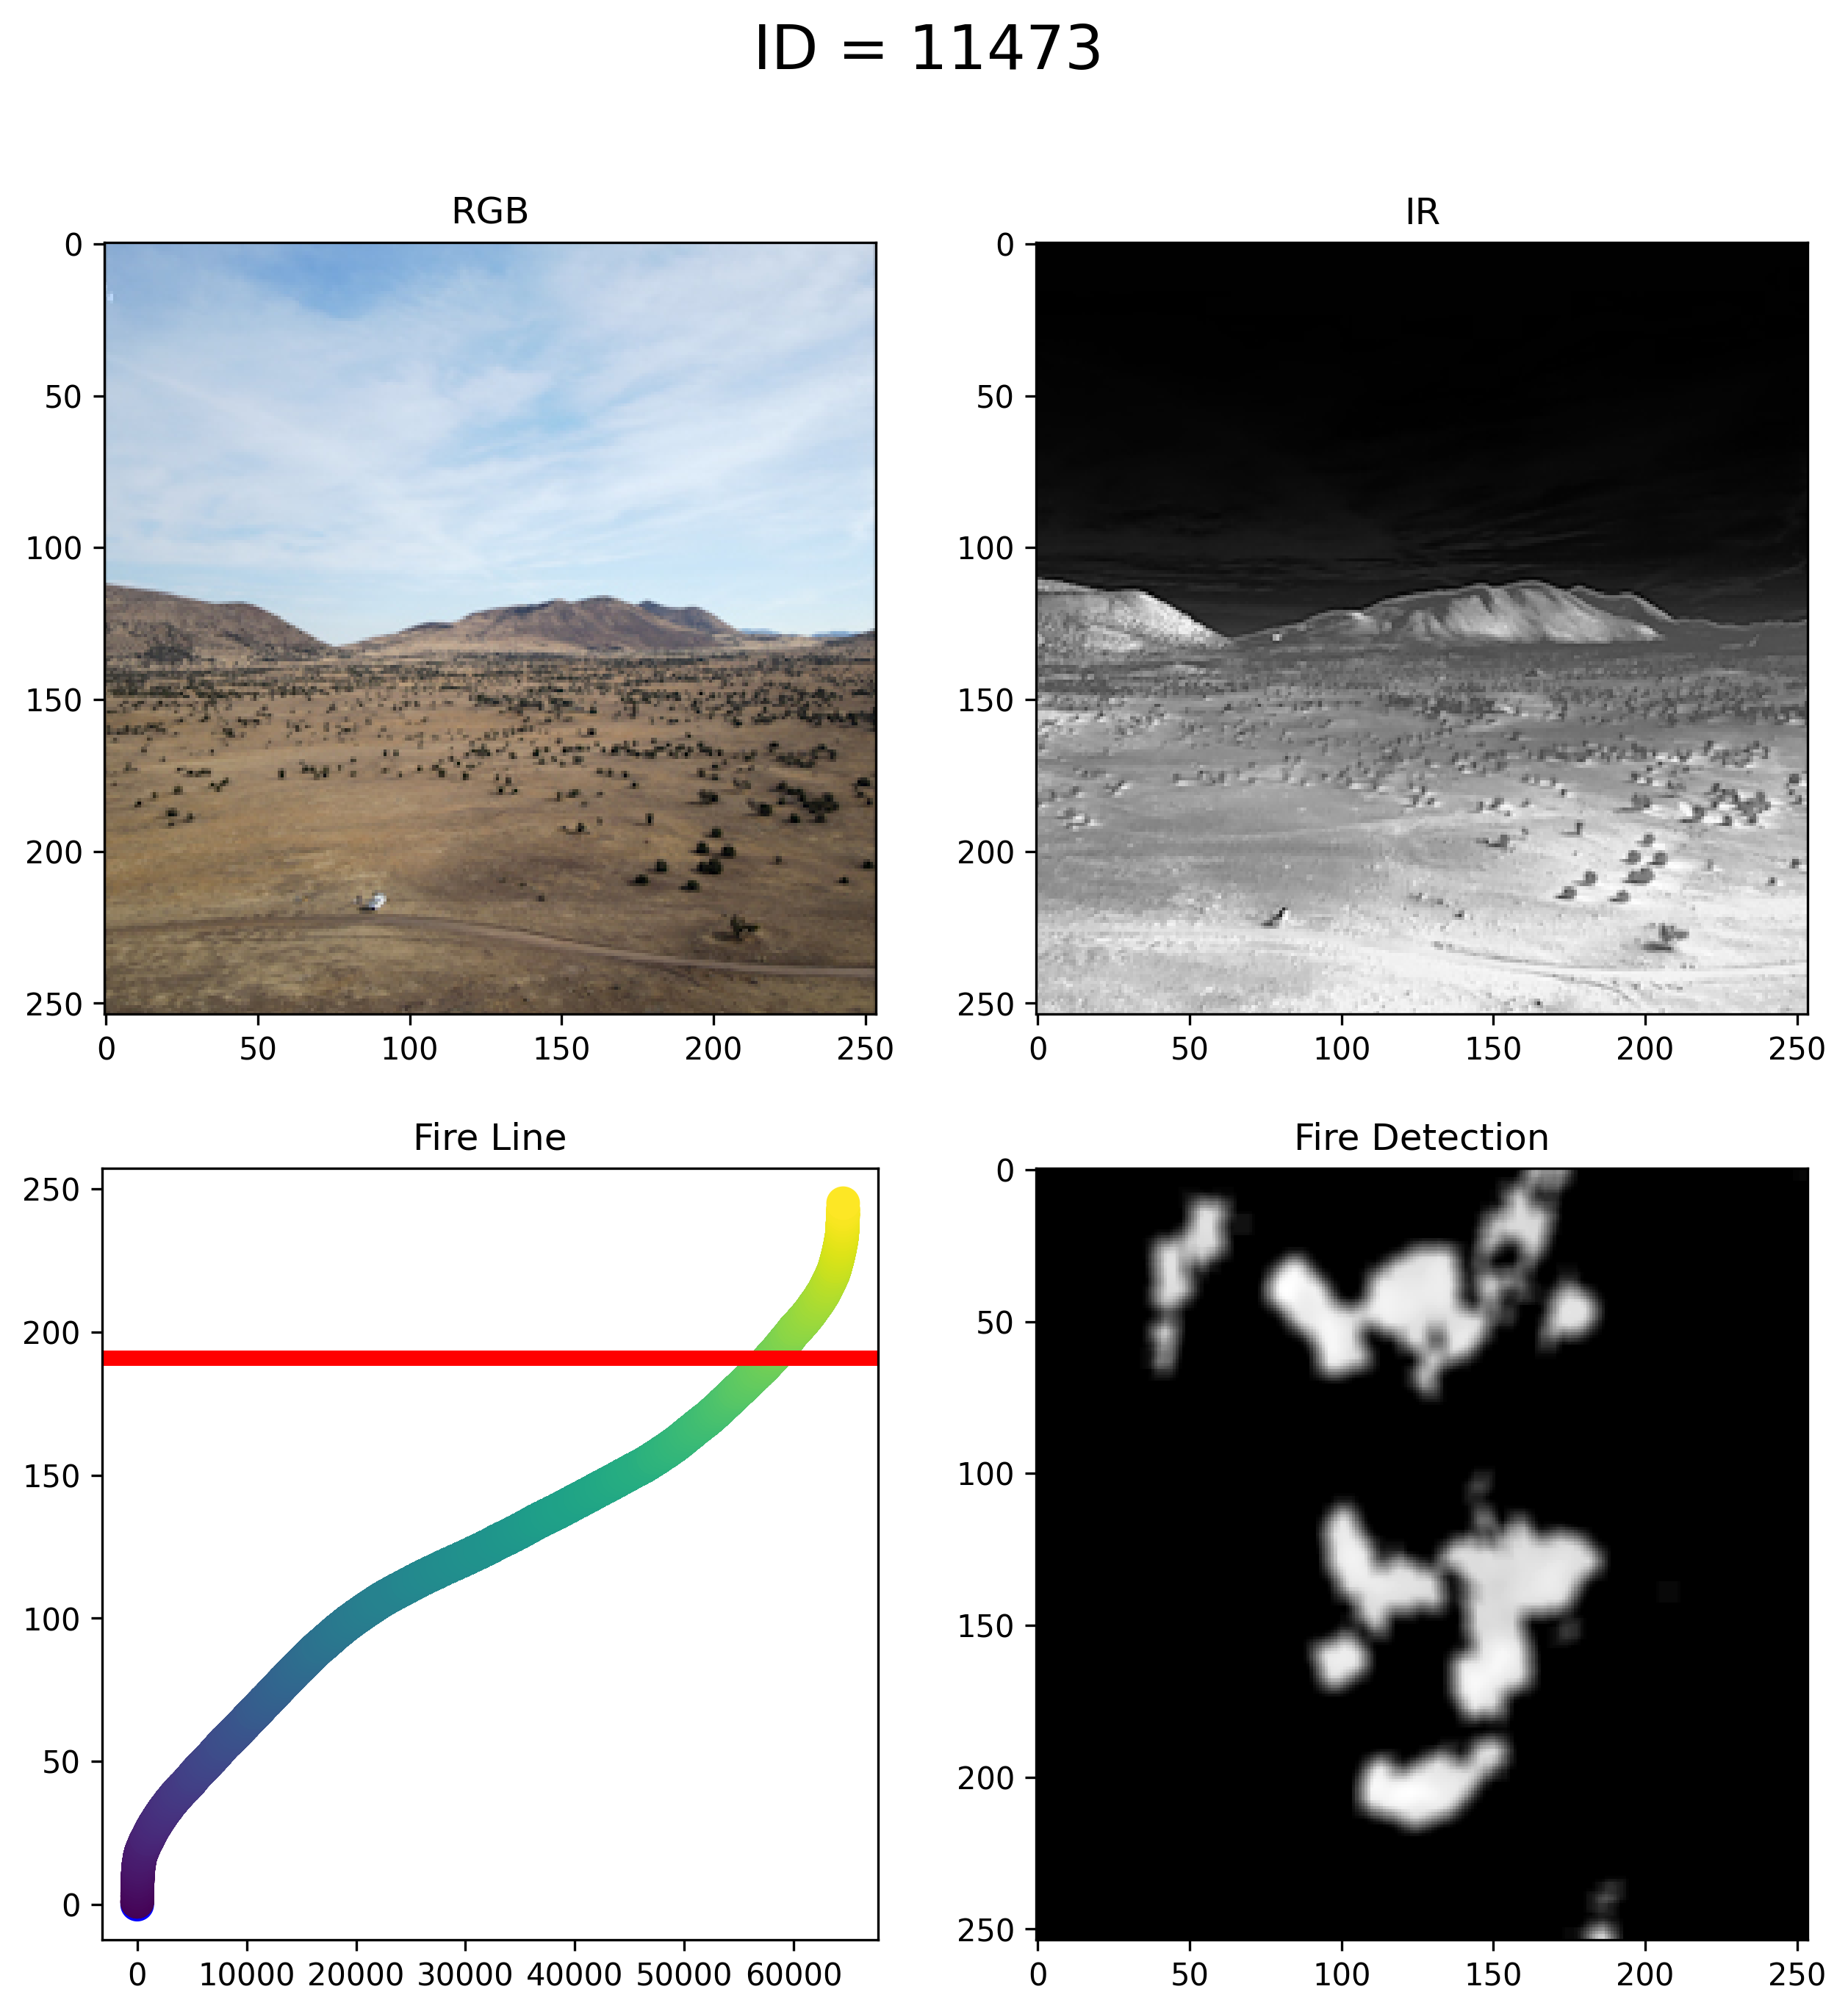

In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

# Path to the RGB images directory
rgb_input_dir = r"D:\Priya\125003238\rgb_input"

# Path to the thermal images directory
path_image_IR = r"D:\Priya\125003238\254p Thermal Images"

# Function to randomly select an image and get its ID
def get_random_image_id(directory):
    rgb_files = os.listdir(directory)
    random_file = random.choice(rgb_files)
    image_id = os.path.splitext(random_file)[0]  # Extract ID from filename
    return int(image_id)

# Function to calculate flame ratio within a box
def Flame_ratio(box, seg_blur):
    x1, y1, x2, y2 = box
    zone = seg_blur[y1:y2, x1:x2]
    w, h = zone.shape
    flame_ratio = np.sum(zone[zone > 0]) / ((w * h + 1) * 255)
    return flame_ratio

# Function for Non-Maximum Suppression (NMS)
def NMS(boxes, overlapThresh, num_areas, flame_thred, seg_blur):
    if len(boxes) == 0:
        return []
    else:
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    areas_order = np.argsort(areas)[::-1]
    boxes = boxes[areas_order]

    indices = np.arange(len(x1))

    for i, box in enumerate(boxes):
        temp_indices = indices[indices != i]
        xx1 = np.maximum(box[0], boxes[temp_indices, 0])
        yy1 = np.maximum(box[1], boxes[temp_indices, 1])
        xx2 = np.minimum(box[2], boxes[temp_indices, 2])
        yy2 = np.minimum(box[3], boxes[temp_indices, 3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]

    boxes = boxes[indices].astype(int)

    flame_list = [Flame_ratio(box, seg_blur) for box in boxes]
    flame_order = np.argsort(flame_list)[::-1].astype(int)  
    flame_list = [flame_list[i] for i in flame_order]  
    boxes = [boxes[i] for i in flame_order]  

    boxes = np.delete(boxes, np.where(np.array(flame_list) < flame_thred), 0)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    boxes = boxes[0:num_areas]
    return boxes


# Get a random image ID from the RGB images directory
image_index = get_random_image_id(rgb_input_dir)

# Load the RGB image using PIL
image_RGB_path = os.path.join(rgb_input_dir, str(image_index) + '.jpg')
image_RGB = Image.open(image_RGB_path)

# Load the thermal image using PIL
image_IR_path = os.path.join(path_image_IR, str(image_index) + '.jpg')
image_IR = Image.open(image_IR_path)

print("RGB Image Path:", image_RGB_path)
print("Thermal Image Path:", image_IR_path)

# Convert the thermal image to grayscale
print("Converting thermal image to grayscale...")
gray_IR = image_IR.convert('L')

# Convert the PIL image to a NumPy array
gray_IR_np = np.array(gray_IR)

# Check if the images were loaded successfully
if image_RGB is None:
    raise ValueError("Failed to load RGB image.")
if gray_IR_np is None:
    raise ValueError("Failed to convert thermal image to grayscale.")

# Display some information about the loaded images
print("RGB Image Shape:", np.array(image_RGB).shape)
print("Thermal Image Gray Shape:", gray_IR_np.shape)


if 1 <= image_index <= 13700:
    # If the image ID falls within the specified range
    boxes = []
else:
    # If the image ID doesn't fall within the specified range, continue with MSER detection
    kernel_size = 7
    fire_thred = 0.9
    zone_overlap_thred = 0.9
    flame_thred = 0.1
    num_areas = 100

    gray = np.array(image_RGB.convert('L'))
    thred = np.mean(gray) + np.median(gray)
    gray_sort = np.sort(gray.reshape(-1))
    fire_line = gray_sort[int(len(gray_sort)*fire_thred)]
    seg = gray.copy()
    seg[seg < fire_line] = 0
    seg_blur = cv2.blur(seg, (kernel_size, kernel_size))

    # Detection with MSER
    MSER = cv2.MSER_create(min_area=300)
    reg, boxes = MSER.detectRegions(seg_blur)

# Perform Non-Maximum Suppression (NMS)
boxes_new = NMS(boxes, zone_overlap_thred, num_areas, flame_thred, seg_blur)

# Draw bounding boxes on RGB image
image_RGB_np = np.array(image_RGB)  # Convert PIL image to NumPy array
for box in boxes_new:
    x, y, w, h = box
    cv2.rectangle(image_RGB_np, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Plot the results
plt.figure(figsize=(10, 10), dpi=300)
plt.suptitle('ID = '+str(image_index), fontsize=20)
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(image_RGB_np)
ax1.set_title('RGB')

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(gray_IR, cmap='gray')
ax2.set_title('IR')

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(np.arange(len(gray_sort)), gray_sort, linewidth=5, c=gray_sort, cmap='viridis')
ax3.axhline(y=fire_line, linewidth=5, color='r')
ax3.set_title('Fire Line')

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(seg_blur, cmap='gray')
ax4.set_title('Fire Detection')

plt.show()


RGB Image Path: D:\Priya\125003238\rgb_input\22696.jpg
Thermal Image Path: D:\Priya\125003238\254p Thermal Images\22696.jpg
Converting thermal image to grayscale...
RGB Image Shape: (254, 254, 3)
Thermal Image Gray Shape: (254, 254)


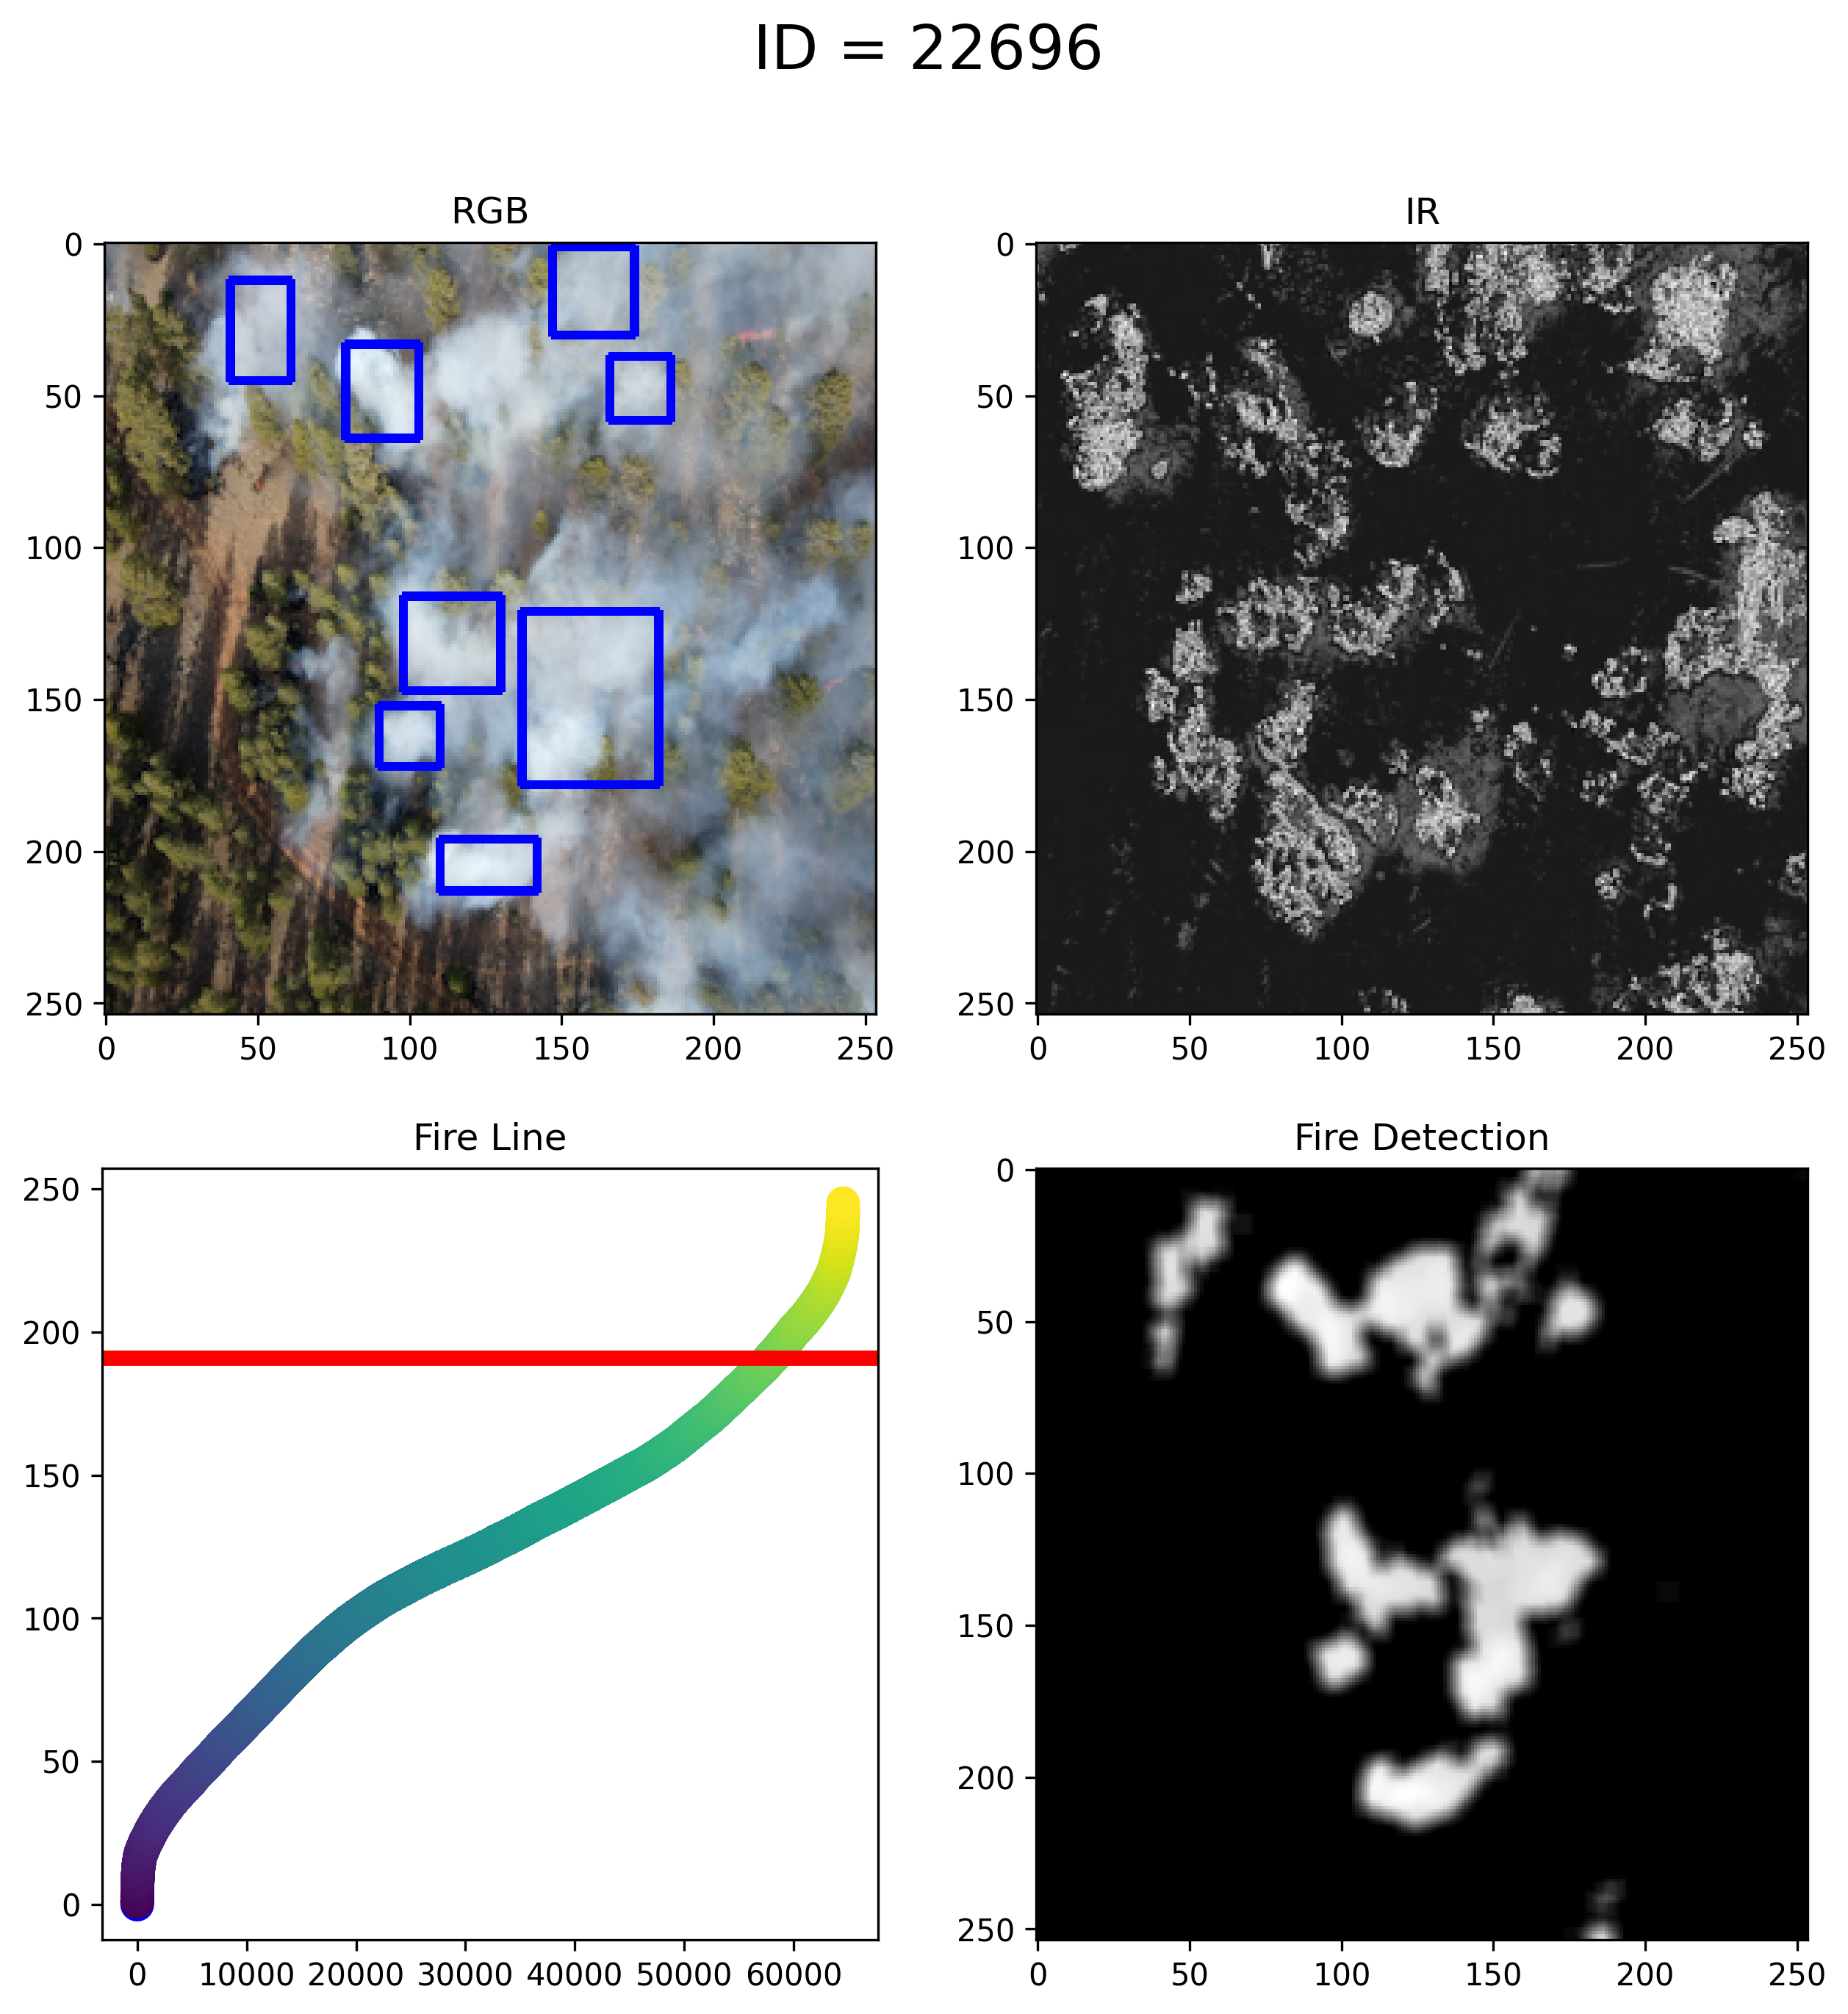

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

# Path to the RGB images directory
rgb_input_dir = r"D:\Priya\125003238\rgb_input"

# Path to the thermal images directory
path_image_IR = r"D:\Priya\125003238\254p Thermal Images"

# Function to randomly select an image and get its ID
def get_random_image_id(directory):
    rgb_files = os.listdir(directory)
    random_file = random.choice(rgb_files)
    image_id = os.path.splitext(random_file)[0]  # Extract ID from filename
    return int(image_id)

# Function to calculate flame ratio within a box
def Flame_ratio(box, seg_blur):
    x1, y1, x2, y2 = box
    zone = seg_blur[y1:y2, x1:x2]
    w, h = zone.shape
    flame_ratio = np.sum(zone[zone > 0]) / ((w * h + 1) * 255)
    return flame_ratio

# Function for Non-Maximum Suppression (NMS)
def NMS(boxes, overlapThresh, num_areas, flame_thred, seg_blur):
    if len(boxes) == 0:
        return []
    else:
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    areas_order = np.argsort(areas)[::-1]
    boxes = boxes[areas_order]

    indices = np.arange(len(x1))

    for i, box in enumerate(boxes):
        temp_indices = indices[indices != i]
        xx1 = np.maximum(box[0], boxes[temp_indices, 0])
        yy1 = np.maximum(box[1], boxes[temp_indices, 1])
        xx2 = np.minimum(box[2], boxes[temp_indices, 2])
        yy2 = np.minimum(box[3], boxes[temp_indices, 3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]

    boxes = boxes[indices].astype(int)

    flame_list = [Flame_ratio(box, seg_blur) for box in boxes]
    flame_order = np.argsort(flame_list)[::-1].astype(int)  
    flame_list = [flame_list[i] for i in flame_order]  
    boxes = [boxes[i] for i in flame_order]  

    boxes = np.delete(boxes, np.where(np.array(flame_list) < flame_thred), 0)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    boxes = boxes[0:num_areas]
    return boxes

# Get a random image ID from the RGB images directory
image_index = get_random_image_id(rgb_input_dir)

# Load the RGB image using PIL
image_RGB_path = os.path.join(rgb_input_dir, str(image_index) + '.jpg')
image_RGB = Image.open(image_RGB_path)

# Load the thermal image using PIL
image_IR_path = os.path.join(path_image_IR, str(image_index) + '.jpg')
image_IR = Image.open(image_IR_path)

print("RGB Image Path:", image_RGB_path)
print("Thermal Image Path:", image_IR_path)

# Convert the thermal image to grayscale
print("Converting thermal image to grayscale...")
gray_IR = image_IR.convert('L')

# Convert the PIL image to a NumPy array
gray_IR_np = np.array(gray_IR)

# Check if the images were loaded successfully
if image_RGB is None:
    raise ValueError("Failed to load RGB image.")
if gray_IR_np is None:
    raise ValueError("Failed to convert thermal image to grayscale.")

# Display some information about the loaded images
print("RGB Image Shape:", np.array(image_RGB).shape)
print("Thermal Image Gray Shape:", gray_IR_np.shape)


kernel_size = 7
fire_thred = 0.9
zone_overlap_thred = 0.9
flame_thred = 0.1
num_areas = 100

gray = np.array(image_RGB.convert('L'))
thred = np.mean(gray) + np.median(gray)
gray_sort = np.sort(gray.reshape(-1))
fire_line = gray_sort[int(len(gray_sort)*fire_thred)]
seg = gray.copy()
seg[seg < fire_line] = 0
seg_blur = cv2.blur(seg, (kernel_size, kernel_size))

# Detection with MSER
MSER = cv2.MSER_create(min_area=300)
reg, boxes = MSER.detectRegions(seg_blur)

# Perform Non-Maximum Suppression (NMS)
boxes_new = NMS(boxes, zone_overlap_thred, num_areas, flame_thred, seg_blur)

# Draw bounding boxes on RGB image
image_RGB_np = np.array(image_RGB)  # Convert PIL image to NumPy array
for box in boxes_new:
    x, y, w, h = box
    cv2.rectangle(image_RGB_np, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Plot the results
plt.figure(figsize=(10, 10), dpi=300)
plt.suptitle('ID = '+str(image_index), fontsize=20)
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(image_RGB_np)
ax1.set_title('RGB')

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(gray_IR, cmap='gray')
ax2.set_title('IR')

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(np.arange(len(gray_sort)), gray_sort, linewidth=5, c=gray_sort, cmap='viridis')
ax3.axhline(y=fire_line, linewidth=5, color='r')
ax3.set_title('Fire Line')

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(seg_blur, cmap='gray')
ax4.set_title('Fire Detection')

plt.show()


RGB Image Path: D:\Priya\125003238\rgb_input\46537.jpg
Thermal Image Path: D:\Priya\125003238\254p Thermal Images\46537.jpg
Converting thermal image to grayscale...
RGB Image Shape: (254, 254, 3)
Thermal Image Gray Shape: (254, 254)


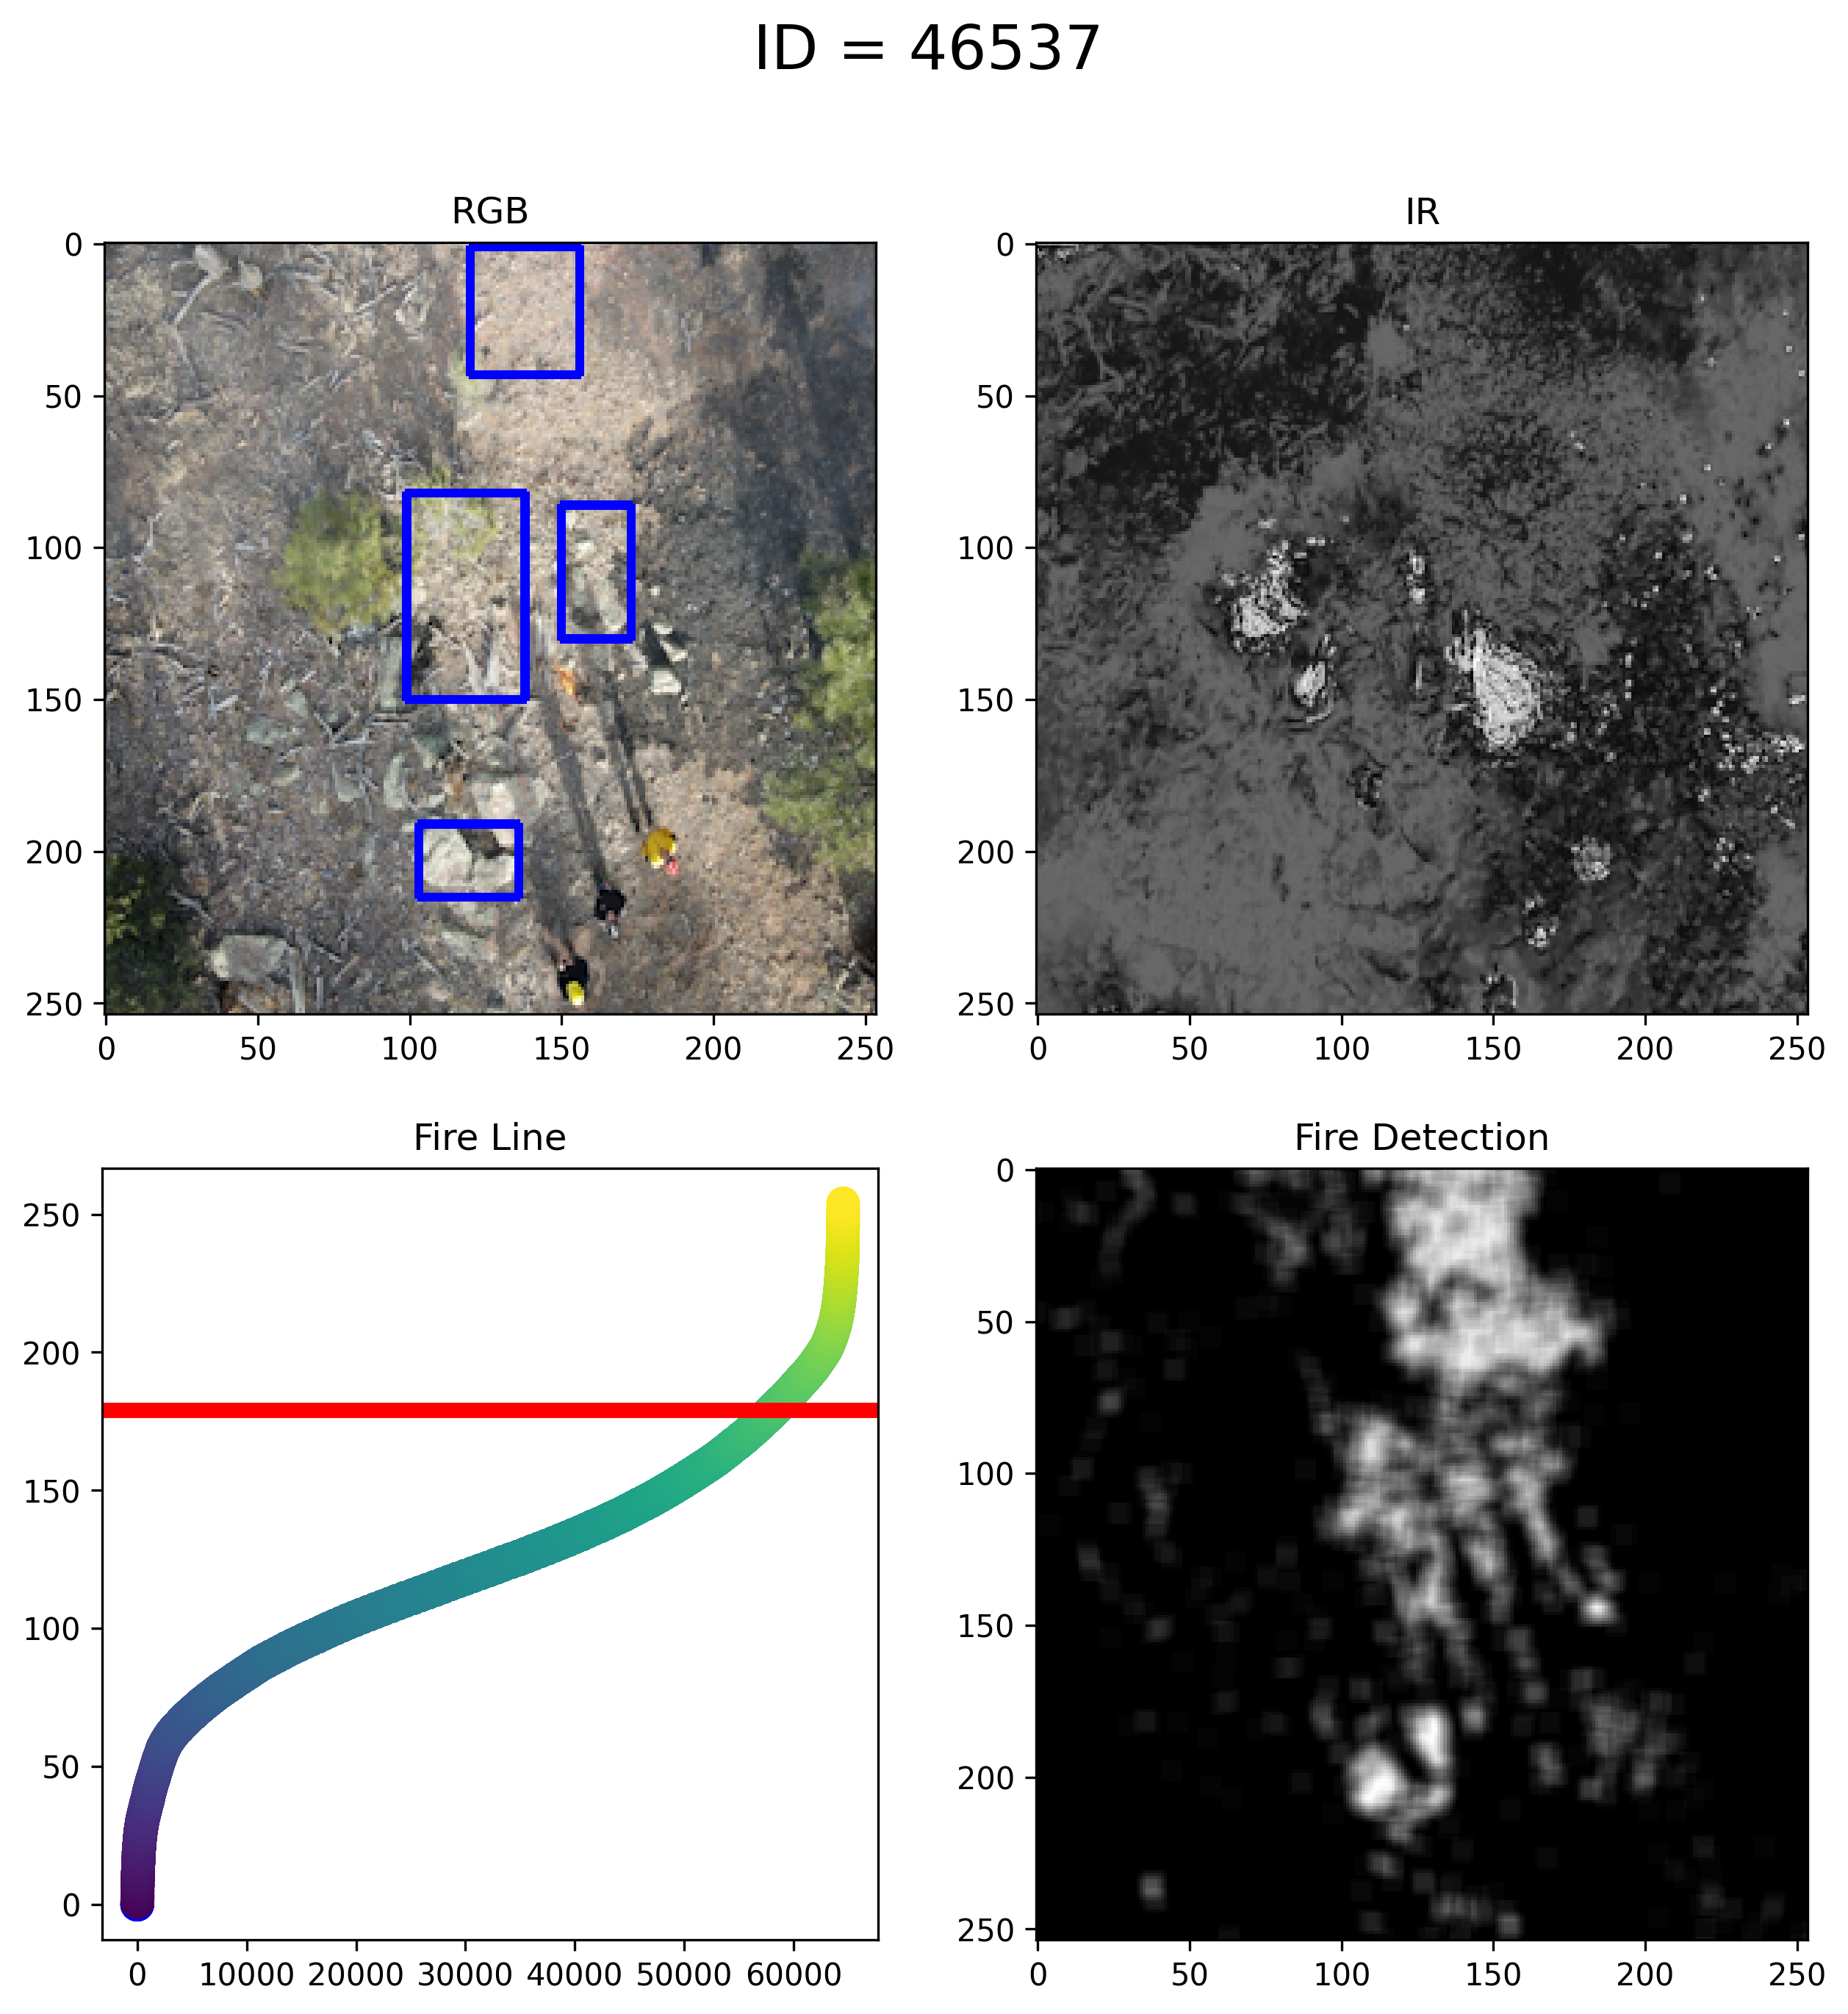

In [65]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

# Path to the RGB images directory
rgb_input_dir = r"D:\Priya\125003238\rgb_input"

# Path to the thermal images directory
path_image_IR = r"D:\Priya\125003238\254p Thermal Images"

# Function to randomly select an image and get its ID
def get_random_image_id(directory):
    rgb_files = os.listdir(directory)
    random_file = random.choice(rgb_files)
    image_id = os.path.splitext(random_file)[0]  # Extract ID from filename
    return int(image_id)

# Function to calculate flame ratio within a box
def Flame_ratio(box, seg_blur):
    x1, y1, x2, y2 = box
    zone = seg_blur[y1:y2, x1:x2]
    w, h = zone.shape
    flame_ratio = np.sum(zone[zone > 0]) / ((w * h + 1) * 255)
    return flame_ratio

# Function for Non-Maximum Suppression (NMS)
def NMS(boxes, overlapThresh, num_areas, flame_thred, seg_blur):
    if len(boxes) == 0:
        return []
    else:
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    areas_order = np.argsort(areas)[::-1]
    boxes = boxes[areas_order]

    indices = np.arange(len(x1))

    for i, box in enumerate(boxes):
        temp_indices = indices[indices != i]
        xx1 = np.maximum(box[0], boxes[temp_indices, 0])
        yy1 = np.maximum(box[1], boxes[temp_indices, 1])
        xx2 = np.minimum(box[2], boxes[temp_indices, 2])
        yy2 = np.minimum(box[3], boxes[temp_indices, 3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]

    boxes = boxes[indices].astype(int)

    flame_list = [Flame_ratio(box, seg_blur) for box in boxes]
    flame_order = np.argsort(flame_list)[::-1].astype(int)  
    flame_list = [flame_list[i] for i in flame_order]  
    boxes = [boxes[i] for i in flame_order]  

    boxes = np.delete(boxes, np.where(np.array(flame_list) < flame_thred), 0)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    boxes = boxes[0:num_areas]
    return boxes

# Get a random image ID from the RGB images directory
image_index = get_random_image_id(rgb_input_dir)

# Load the RGB image using PIL
image_RGB_path = os.path.join(rgb_input_dir, str(image_index) + '.jpg')
image_RGB = Image.open(image_RGB_path)

# Load the thermal image using PIL
image_IR_path = os.path.join(path_image_IR, str(image_index) + '.jpg')
image_IR = Image.open(image_IR_path)

print("RGB Image Path:", image_RGB_path)
print("Thermal Image Path:", image_IR_path)

# Convert the thermal image to grayscale
print("Converting thermal image to grayscale...")
gray_IR = image_IR.convert('L')

# Convert the PIL image to a NumPy array
gray_IR_np = np.array(gray_IR)

# Check if the images were loaded successfully
if image_RGB is None:
    raise ValueError("Failed to load RGB image.")
if gray_IR_np is None:
    raise ValueError("Failed to convert thermal image to grayscale.")

# Display some information about the loaded images
print("RGB Image Shape:", np.array(image_RGB).shape)
print("Thermal Image Gray Shape:", gray_IR_np.shape)


kernel_size = 7
fire_thred = 0.9
zone_overlap_thred = 0.9
flame_thred = 0.1
num_areas = 100

gray = np.array(image_RGB.convert('L'))
thred = np.mean(gray) + np.median(gray)
gray_sort = np.sort(gray.reshape(-1))
fire_line = gray_sort[int(len(gray_sort)*fire_thred)]
seg = gray.copy()
seg[seg < fire_line] = 0
seg_blur = cv2.blur(seg, (kernel_size, kernel_size))

# Detection with MSER
MSER = cv2.MSER_create(min_area=300)
reg, boxes = MSER.detectRegions(seg_blur)

# Perform Non-Maximum Suppression (NMS)
boxes_new = NMS(boxes, zone_overlap_thred, num_areas, flame_thred, seg_blur)

# Draw bounding boxes on RGB image
image_RGB_np = np.array(image_RGB)  # Convert PIL image to NumPy array
for box in boxes_new:
    x, y, w, h = box
    cv2.rectangle(image_RGB_np, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Plot the results
plt.figure(figsize=(10, 10), dpi=300)
plt.suptitle('ID = '+str(image_index), fontsize=20)
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(image_RGB_np)
ax1.set_title('RGB')

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(gray_IR, cmap='gray')
ax2.set_title('IR')

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(np.arange(len(gray_sort)), gray_sort, linewidth=5, c=gray_sort, cmap='viridis')
ax3.axhline(y=fire_line, linewidth=5, color='r')
ax3.set_title('Fire Line')

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(seg_blur, cmap='gray')
ax4.set_title('Fire Detection')

plt.show()
